* Add wind speed, 

* M-O approaches to latent heat flux, 
* Find downvalley potential temp, noting elevation of each

In [1]:
import os
import act
import glob
import xarray as xr

import sys
sys.path.append('/home/elilouis/sublimationofsnow')
import sosutils
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import pytz
import datetime
import metpy
from metpy.units import units

import numpy as np

import altair as alt
alt.data_transformers.disable_max_rows()
alt.data_transformers.enable('json')
alt.renderers.enable('svg')

import seaborn as sns
import xarray as xr

# User Inputs

In [2]:
# datelist = ['20221031', '20221101', '20221102', '20221103']
# datelist = ['20221217', '20221218', '20221219', '20221220', '20221221']
# datelist = ['20230217', '20230218', '20230219', '20230220', '20230221']
# datelist = ['20230131', '20230201', '20230202', '20230203']
datelist = ['20230204', '20230205', '20230206', '20230207', '20230208']

REMOVE_1M_DATA = False

## SOS

In [3]:
sos_download_dir='/data2/elilouis/sublimationofsnow/sosnoqc'
DATE_FORMAT_STR = '%Y%m%d'
start_date = datelist[0]
end_date = datelist[-1]

### Define variable list to extract

In [4]:
VARIABLE_NAMES = [  
    'spd_1m_c',     'dir_1m_c',     'u_1m_c',   'v_1m_c',   'w_1m_c',   'u_w__1m_c',    'v_w__1m_c',  'u_tc__1m_c',  'v_tc__1m_c',   'u_h2o__1m_c',  'v_h2o__1m_c',   'w_tc__1m_c',   'w_h2o__1m_c',
    'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',   'w_2m_c',   'u_w__2m_c',    'v_w__2m_c',  'u_tc__2m_c',  'v_tc__2m_c',   'u_h2o__2m_c',  'v_h2o__2m_c',   'w_tc__2m_c',   'w_h2o__2m_c',
    'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',   'w_3m_c',   'u_w__3m_c',    'v_w__3m_c',  'u_tc__3m_c',  'v_tc__3m_c',   'u_h2o__3m_c',  'v_h2o__3m_c',   'w_tc__3m_c',   'w_h2o__3m_c',
    'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',   'w_5m_c',   'u_w__5m_c',    'v_w__5m_c',  'u_tc__5m_c',  'v_tc__5m_c',   'u_h2o__5m_c',  'v_h2o__5m_c',   'w_tc__5m_c',   'w_h2o__5m_c',
    'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',  'w_10m_c',  'u_w__10m_c',   'v_w__10m_c', 'u_tc__10m_c', 'v_tc__10m_c',  'u_h2o__10m_c', 'v_h2o__10m_c',  'w_tc__10m_c',  'w_h2o__10m_c',
    'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',  'w_15m_c',  'u_w__15m_c',   'v_w__15m_c', 'u_tc__15m_c', 'v_tc__15m_c',  'u_h2o__15m_c', 'v_h2o__15m_c',  'w_tc__15m_c',  'w_h2o__15m_c',
    'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',  'w_20m_c',  'u_w__20m_c',   'v_w__20m_c', 'u_tc__20m_c', 'v_tc__20m_c',  'u_h2o__20m_c', 'v_h2o__20m_c',  'w_tc__20m_c',  'w_h2o__20m_c',
    
    'tc_1m_c', 'tc_2m_c', 'tc_3m_c', 'tc_5m_c', 'tc_10m_c', 'tc_15m_c', 'tc_20m_c',

    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c',
    'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c',
    'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    'RH_1m_c', 'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    'SF_avg_1m_ue', 'SF_avg_2m_ue'
]
if REMOVE_1M_DATA:
    VARIABLE_NAMES = [f for f in VARIABLE_NAMES if not '_1m_' in f]

## SAIL - ECOR

In [4]:
ecor_gothic = 'guc30ecorM1.b1'
ecor_kp = 'guc30ecorS3.b1'
met_gothic = 'gucmetM1.b1'
met_kp = 'gucmetS3.b1'

start_date = datelist[0]
end_date = datelist[-1]

output_dir = '/data2/elilouis/sublimationofsnow/'
ecor_gothic_path = os.path.join(output_dir, ecor_gothic)
ecor_kp_path = os.path.join(output_dir, ecor_kp)
met_gothic_path = os.path.join(output_dir, met_gothic)
met_kp_path = os.path.join(output_dir, met_kp)

In [5]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

## SPLASH - ASFS

In [7]:
splash_file_dir = '/data2/elilouis/sublimationofsnow/splash_for_eli_late_2022/'
all_splash_files = os.listdir(splash_file_dir)
len(all_splash_files)
daily_splash_files = []
for date in datelist:
    daily_splash_files = daily_splash_files + [f for f in all_splash_files if date in f]
len(daily_splash_files)

0

In [8]:
averypicnic_slowsled_files = [os.path.join(splash_file_dir, f) for f in daily_splash_files if 'slowsled' in f and 'picnic' in f]
averypicnic_turbsled_files = [os.path.join(splash_file_dir, f) for f in daily_splash_files if 'turbsled' in f and 'picnic' in f]
ponds_slowsled_files = [os.path.join(splash_file_dir, f) for f in daily_splash_files if 'slowsled' in f and 'pond' in f]
ponds_turbsled_files = [os.path.join(splash_file_dir, f) for f in daily_splash_files if 'turbsled' in f and 'pond' in f]

In [9]:
averypicnic_slowsled_xr = xr.open_mfdataset(averypicnic_slowsled_files)
averypicnic_turbsled_xr = xr.open_mfdataset(averypicnic_turbsled_files)

OSError: no files to open

In [ ]:
# fails for some reason
pond_slowsled_xr = xr.open_mfdataset(ponds_slowsled_files[:3])
# No turbulence data at KPS data for these days???
# pond_turbsled_xr = xr.open_mfdataset(ponds_turbsled_files)

In [ ]:
averypicnic_slowsled_xr = sosutils.modify_xarray_timezone(averypicnic_slowsled_xr, pytz.UTC, pytz.timezone('US/Mountain'))
pond_slowsled_xr = sosutils.modify_xarray_timezone(pond_slowsled_xr, pytz.UTC, pytz.timezone('US/Mountain'))

## Snotel (Schofield)

In [ ]:
from metloom.pointdata import SnotelPointData

In [ ]:
snotel_point = SnotelPointData("737:CO:SNTL", "Schofield")

# Data Download

## SOS

In [ ]:
example_dataset = xr.open_dataset(sosutils.download_sos_data_day(datelist[0], sos_download_dir))

In [ ]:
datasets = [xr.open_dataset(sosutils.download_sos_data_day(date, sos_download_dir))[VARIABLE_NAMES] for date in datelist]
sos_ds = sosutils.merge_datasets_with_different_variables(datasets, dim='time')
sos_ds = sosutils.modify_xarray_timezone(sos_ds, pytz.UTC, pytz.timezone('US/Mountain'))
sos_df = sos_ds.to_dataframe().reset_index()

## ECOR

In [21]:
from tempfile import TemporaryDirectory
# with TemporaryDirectory() as temp_dir:
#     act.discovery.download_data(
#         username,    token,    ecor_gothic,    start_date,    end_date,
#         output = temp_dir
#     )
#     ecor_gothic_ds = act.io.armfiles.read_netcdf(glob.glob(os.path.join(temp_dir, '*.cdf')))
#     ecor_gothic_ds = sosutils.modify_xarray_timezone(ecor_gothic_ds, pytz.UTC, pytz.timezone('US/Mountain'))

# with TemporaryDirectory() as temp_dir:
#     act.discovery.download_data(
#         username,    token,    ecor_kp,    start_date,    end_date,
#         output = temp_dir
#     )
#     ecor_kps_ds = act.io.armfiles.read_netcdf(glob.glob(os.path.join(temp_dir, '*.cdf')))
#     ecor_kps_ds = sosutils.modify_xarray_timezone(ecor_kps_ds, pytz.UTC, pytz.timezone('US/Mountain'))


with TemporaryDirectory() as temp_dir:
    act.discovery.download_data(
        username,    token,    ,    start_date,    end_date,
        output = temp_dir
    )
    met_gothic_ds = act.io.armfiles.read_netcdf(glob.glob(os.path.join(temp_dir, '*.cdf')))
    met_gothic_ds = sosutils.modify_xarray_timezone(met_gothic_ds, pytz.UTC, pytz.timezone('US/Mountain'))

No files returned or url status error.
Check datastream name, start, and end date.


OSError: no files to open

In [20]:
for var in met_gothic_ds.data_vars:
    print(met_gothic_ds[var].attrs['long_name'])

Base time in Epoch
Time offset from base_time
Time cell bounds
Upwelling Longwave Hemispheric Irradiance, Pyrgeometer
Quality check results on variable: Upwelling Longwave Hemispheric Irradiance, Pyrgeometer
Upwelling Shortwave Hemispheric Irradiance, Pyranometer
Quality check results on variable: Upwelling Shortwave Hemispheric Irradiance, Pyranometer
Upwelling Longwave Hemispheric Irradiance, Pyrgeometer, Standard Deviation
Upwelling Shortwave Hemispheric Irradiance, Pyranometer, Standard Deviation
Upwelling Longwave Hemispheric Irradiance, Pyrgeometer, Maxima
Quality check results on variable: Upwelling Longwave Hemispheric Irradiance, Pyrgeometer, Maxima
Upwelling Shortwave Hemispheric Irradiance, Pyranometer, Maxima
Quality check results on variable: Upwelling Shortwave Hemispheric Irradiance, Pyranometer, Maxima
Upwelling Longwave Hemispheric Irradiance, Pyrgeometer, Minima
Quality check results on variable: Upwelling Longwave Hemispheric Irradiance, Pyrgeometer, Minima
Upwelling

## SNOTEL

In [ ]:
snotel_df = snotel_point.get_hourly_data(
    datetime.datetime.strptime(datelist[0], DATE_FORMAT_STR),
    datetime.datetime.strptime(datelist[-1], DATE_FORMAT_STR),
    [
        snotel_point.ALLOWED_VARIABLES.SWE,
        snotel_point.ALLOWED_VARIABLES.RH,
        snotel_point.ALLOWED_VARIABLES.TEMP,
    ]
)
snotel_df = snotel_df.reset_index().set_index('datetime').tz_convert('US/Mountain').tz_localize(None)

# Calculations

## Potential temperatures

In [ ]:
import pint_xarray

In [ ]:
# SAIL gothic met tower
met_gothic_ds['potential temperature'] \
                        = metpy.calc.potential_temperature(met_gothic_ds['atmos_pressure'] * units.kPa, met_gothic_ds['temp_mean'] * units.celsius).pint.to(units.celsius)

# SOS towers
if REMOVE_1M_DATA:
    height_range = range(2,21)
else:
    height_range = range(1,21)
for i in height_range:
    height_adj_pressure = metpy.calc.add_height_to_pressure(
        sos_ds['P_10m_c'] * units.millibar, 
        i*units.m - (10*units.m)
    )
    sos_ds[f'Tpot_{i}m_c'] = metpy.calc.potential_temperature(    
        height_adj_pressure,
        sos_ds[f'T_{i}m_c'] * units.celsius
    ).pint.to(units.celsius)


### Calculate for schofield using KPS /SOS reference pressures

In [ ]:
import py3dep
kettle_ponds = [-106.973006, 38.942005]
kps_elevation = py3dep.elevation_bycoords([kettle_ponds])[0] * units.meters
schofield_elevation = (snotel_df.geometry.iloc[0].coords[-1][-1] * units.feet).to(units.meters)
# calculate difference in elevation between the KPS site and Schofield Pass Snotel Site
schofield_gothic_elev_diff = schofield_elevation - kps_elevation

In [ ]:
# calculate hourly average pressure values at KPS
sos_kps_10m_p_hourly = sos_ds.to_dataframe()['P_10m_c'].resample("60Min").mean()
# convert KPS hourly average pressure values to pressures at the Schofield Pass Snotel Site
snotel_df['pressure'] = snotel_df.index.get_level_values(0).to_series().apply(
    lambda dt: metpy.calc.add_height_to_pressure(
        sos_kps_10m_p_hourly[dt] * units.millibar, 
        schofield_gothic_elev_diff - (10*units.m)
    ) if dt in sos_kps_10m_p_hourly.index else np.nan * units.millibar
).values

snotel_df['AIR TEMP'] = snotel_df['AIR TEMP'].apply(lambda x: x * units.fahrenheit).values


snotel_df['potential temperature'] = snotel_df.apply(
    lambda row: metpy.calc.potential_temperature(row['pressure'], row['AIR TEMP']).to(units.celsius),
    axis=1
)

## Sublimation/evaporation

In [ ]:
ecor_kps_ds['sublimation rate (mm/hr)'] = 3600*ecor_kps_ds['lv_e']/2.838e6
ecor_gothic_ds['sublimation rate (mm/hr)'] = 3600*ecor_gothic_ds['lv_e']/2.838e6
sos_ds['sublimation rate (mm/hr)'] = 3600*sos_ds['w_h2o__3m_c']/1e3
sos_ds['lv_e'] = (sos_ds['w_h2o__3m_c']/1e3)*2.838e6

## Modify SPLASH wind direction to be "direction wind blows from" instead of "direction wind blows towards"

In [ ]:
averypicnic_slowsled_xr['wdir_vec_mean'].values = np.array([
    (x-180) if (x-180) > 0 else 360+(x-180) for x in averypicnic_slowsled_xr['wdir_vec_mean'].values
])
# let wind dir go up to 390 degrees to plot better
averypicnic_slowsled_xr['wdir_vec_mean'].values = np.array([
    (x+360) if x < 30 else x for x in averypicnic_slowsled_xr['wdir_vec_mean'].values
])

# Plot

## Get nighttime df

In [ ]:
import matplotlib.dates as mdates
from matplotlib import dates

night_df = sosutils.get_nightime_df(
    'US/Mountain', 
    ecor_gothic_ds['lat'].values[0], 
    ecor_gothic_ds['lon'].values[0],
    [datetime.datetime.strptime(date_str, '%Y%m%d') for date_str in ecor_gothic_ds.attrs['_file_dates']]
)

## Wind dir, pot. temps, and moisture fluxes at Gothic and KPS sites

#### Resample data for plotting and get a local time dimension

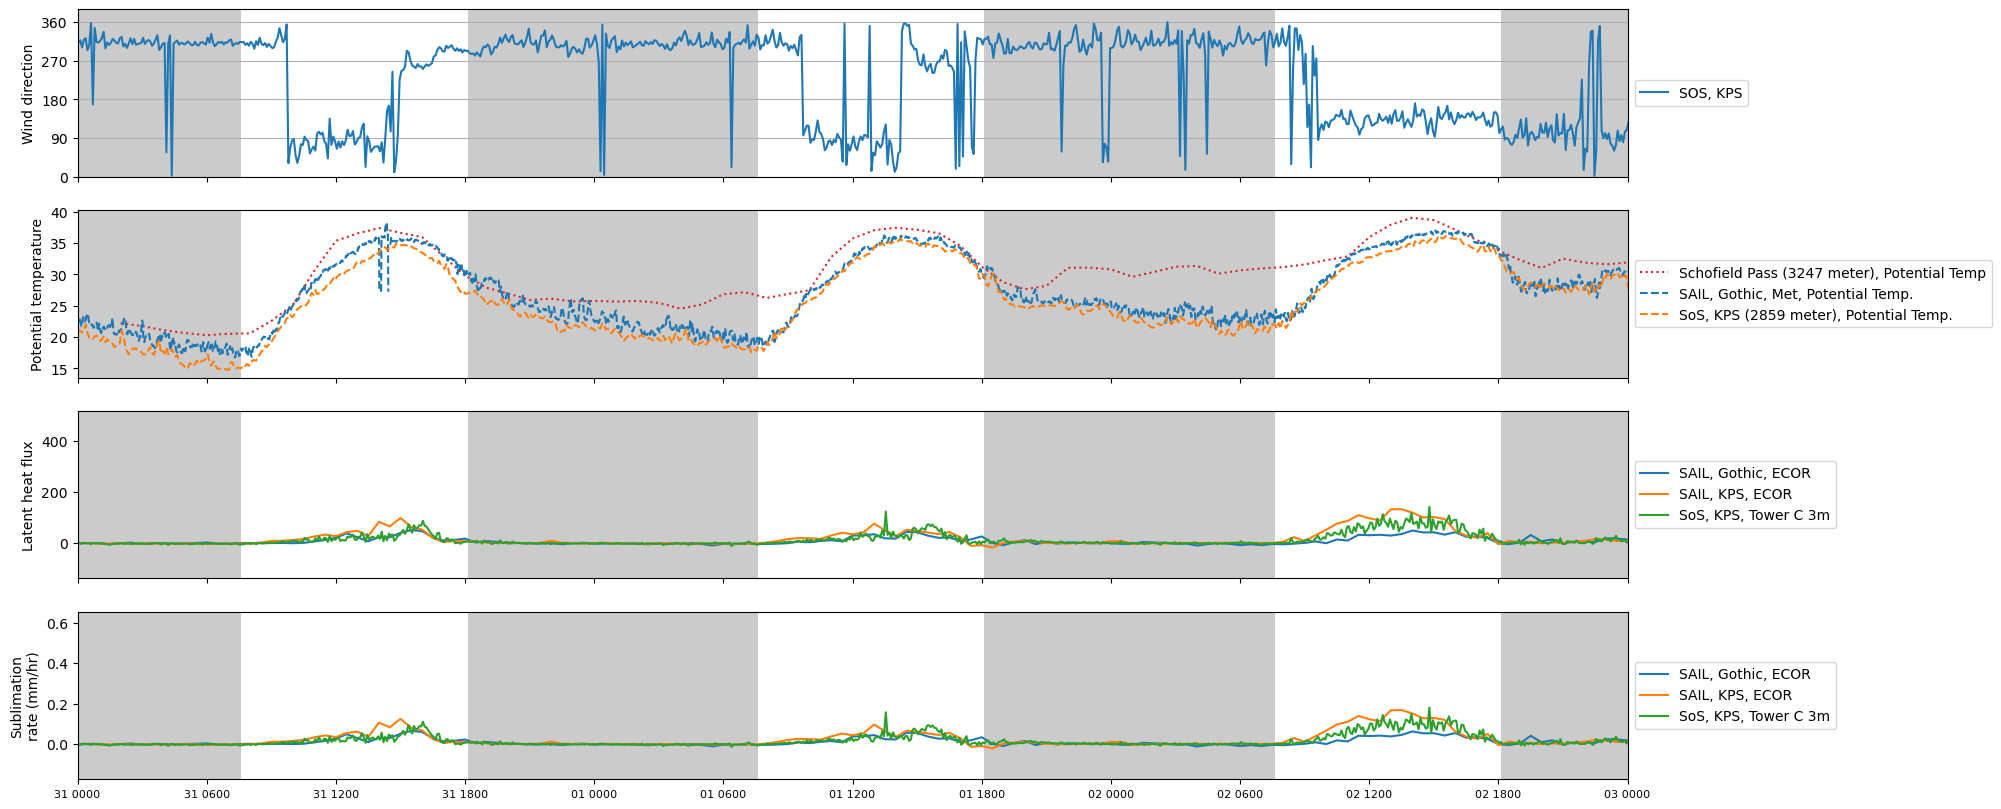

In [ ]:
fig, axes = plt.subplots(4,1, figsize=(20,10), sharex=True)

# plot
# axes[0].plot(averypicnic_slowsled_xr['time (US/Mountain)'], averypicnic_slowsled_xr['wdir_vec_mean'], label = "SPLASH, Avery Picnic")
# axes[0].plot(met_gothic_ds_5min['time (US/Mountain)'], met_gothic_ds_5min['wdir_vec_mean'], label='SAIL, Gothic, Met', linewidth=0.75)
axes[0].plot(sos_ds['time (US/Mountain)'], sos_ds['dir_3m_c'], label='SOS, KPS')
# axes[0].plot(pond_slowsled_xr['time (US/Mountain)'], pond_slowsled_xr['wdir_vec_mean'], label = "SPLASH, KPS Annex")
# axes[0].plot(ecor_gothic_ds['time (US/Mountain)'], ecor_gothic_ds['wind_dir'], label='SAIL, Gothic, ECOR')
# axes[0].plot(ecor_kps_ds['time (US/Mountain)'], ecor_kps_ds['wind_dir'], label='SAIL, KPS, ECOR')
axes[0].set_ylabel('Wind direction')
axes[0].set_ylim(0, 390)
axes[0].set_yticks([0, 90, 180, 270, 360])
axes[0].yaxis.grid(True)

axes[1].plot(snotel_df.reset_index().datetime, snotel_df['potential temperature'],label=f"Schofield Pass ({schofield_elevation.astype('int')}), Potential Temp", linestyle=':',color='tab:red')
axes[1].plot(met_gothic_ds['time (US/Mountain)'], met_gothic_ds['potential temperature'], label='SAIL, Gothic, Met, Potential Temp.', linestyle='--', color='tab:blue')
if REMOVE_1M_DATA:
    axes[1].plot(sos_ds['time (US/Mountain)'], sos_ds['Tpot_2m_c'], label=f"SoS, KPS ({kps_elevation.astype('int')}), Potential Temp.", linestyle='--', color='tab:orange')
    # axes[1].plot(sos_ds['time (US/Mountain)'], sos_ds['T_2m_c'], label='SoS, KPS, Temp.', color='tab:orange')
else:
    axes[1].plot(sos_ds['time (US/Mountain)'], sos_ds['Tpot_1m_c'], label=f"SoS, KPS ({kps_elevation.astype('int')}), Potential Temp.", linestyle='--', color='tab:orange')
    # axes[1].plot(sos_ds['time (US/Mountain)'], sos_ds['T_1m_c'], label='SoS, KPS, Temp.', color='tab:orange')
# axes[1].plot(met_gothic_ds['time (US/Mountain)'], met_gothic_ds['temp_mean'], label='SAIL, Gothic, Met, Temp.', color='tab:blue')

axes[1].set_ylabel('Potential temperature')

axes[2].plot(ecor_gothic_ds['time (US/Mountain)'], ecor_gothic_ds['lv_e'], label='SAIL, Gothic, ECOR')
axes[2].plot(ecor_kps_ds['time (US/Mountain)'], ecor_kps_ds['lv_e'], label='SAIL, KPS, ECOR')
axes[2].plot(sos_ds['time (US/Mountain)'], sos_ds['lv_e'], label='SoS, KPS, Tower C 3m')
axes[2].set_ylabel('Latent heat flux')

axes[3].plot(ecor_gothic_ds['time (US/Mountain)'], ecor_gothic_ds['sublimation rate (mm/hr)'], label='SAIL, Gothic, ECOR')
axes[3].plot(ecor_kps_ds['time (US/Mountain)'], ecor_kps_ds['sublimation rate (mm/hr)'], label='SAIL, KPS, ECOR')
axes[3].plot(sos_ds['time (US/Mountain)'], sos_ds['sublimation rate (mm/hr)'], label='SoS, KPS, Tower C 3m')
axes[3].set_ylabel('Sublimation\nrate (mm/hr)')

for ax in axes:
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))   #to get a tick every 4 hrs
    ax.xaxis.set_major_formatter(dates.DateFormatter('%d %H00'))
    ax.xaxis.set_tick_params(labelsize=8)
    # ax.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    for i,row in night_df.iterrows():
        ax.axvspan(row['sunset'], row['sunrise'], facecolor='0.2', alpha=0.25)
    # ax.set_xlim(np.datetime64("2023-02-17"), np.datetime64("2023-02-21"))
    ax.set_xlim(datetime.datetime.strptime(datelist[0], DATE_FORMAT_STR), datetime.datetime.strptime(datelist[-1], DATE_FORMAT_STR))

In [ ]:
snotel_df['time'] = snotel_df.index
snotel_df['potential temperature'] = snotel_df['potential temperature'].apply(lambda x: x.magnitude.item())
snotel_df = snotel_df.set_index('time')[['potential temperature']]

In [ ]:
time_series_data_tidy = pd.concat([
    # averypicnic_slowsled_xr['wdir_vec_mean'].resample(time="5Min").mean().to_dataframe().reset_index().rename(
    #         columns={'wdir_vec_mean': 'value'}
    #     ).assign(variable = 'Wind Direction, Avery Picnic SPLASH'),
    sos_ds['dir_3m_c'].resample(time="5Min").mean().to_dataframe().reset_index().rename(
            columns={'dir_3m_c': 'value'}
        ).assign(variable = 'Wind Direction, Kettle Ponds SOS'),
    snotel_df.resample("5Min").mean().reset_index().rename(
            columns={'potential temperature': 'value'}
        ).assign(variable = 'Pot. Temp, Schofield Pass SNOTEL'),
    met_gothic_ds['potential temperature'].resample(time="5Min").mean().to_dataframe().reset_index().rename(
            columns={'potential temperature': 'value'}
        ).assign(variable = 'Pot. Temp, Gothic SAIL'),
    sos_ds['Tpot_2m_c'].resample(time="5Min").mean().to_dataframe().reset_index().rename(
            columns={'Tpot_2m_c': 'value'}
        ).assign(variable = 'Pot. Temp, Kettle Ponds SOS'),
    ecor_gothic_ds['lv_e'].resample(time="5Min").mean().to_dataframe().reset_index().rename(
            columns={'lv_e': 'value'}
        ).assign(variable = 'LH Flux, Gothic SAIL'),
    ecor_kps_ds['lv_e'].resample(time="5Min").mean().to_dataframe().reset_index().rename(
            columns={'lv_e': 'value'}
        ).assign(variable = 'LH Flux, Kettle Ponds SAIL'),
    sos_ds['lv_e'].resample(time="5Min").mean().to_dataframe().reset_index().rename(
            columns={'lv_e': 'value'}
        ).assign(variable = 'LH Flux, Kettle Ponds SOS')
])

In [ ]:
wind_dir_chart = alt.Chart().transform_filter(
    alt.FieldOneOfPredicate('variable', ['Wind Direction, Avery Picnic SPLASH', 'Wind Direction, Kettle Ponds SOS'])
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q", title='Wind Direction (˚)'),
    alt.Color("variable:N")
).properties(width=800, height=200)

In [ ]:
potential_temp_chart = alt.Chart().transform_filter(
    alt.FieldOneOfPredicate('variable', [
        'Pot. Temp, Schofield Pass SNOTEL',
        'Pot. Temp, Gothic SAIL',
        'Pot. Temp, Kettle Ponds SOS'
    ])
).mark_circle().encode(
    alt.X('time:T'),
    alt.Y("value:Q", title='Potential Temperature (˚C)'),
    alt.Color("variable:N")
).properties(width=800, height=200)

In [ ]:
latent_heat_chart = alt.Chart().transform_filter(
    alt.FieldOneOfPredicate('variable', [
        'LH Flux, Gothic SAIL',
        'LH Flux, Kettle Ponds SAIL',
        'LH Flux, Kettle Ponds SOS'
    ])
).transform_window(
    rolling_mean='mean(value)',
    frame=[-10,10],
    groupby=['variable']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("rolling_mean:Q", title='Latent Heat Flux (w/m^2)', 
        # scale=alt.Scale(domain=[-25, 100])
    ),
    alt.Color("variable:N")
).properties(width=800, height=200)

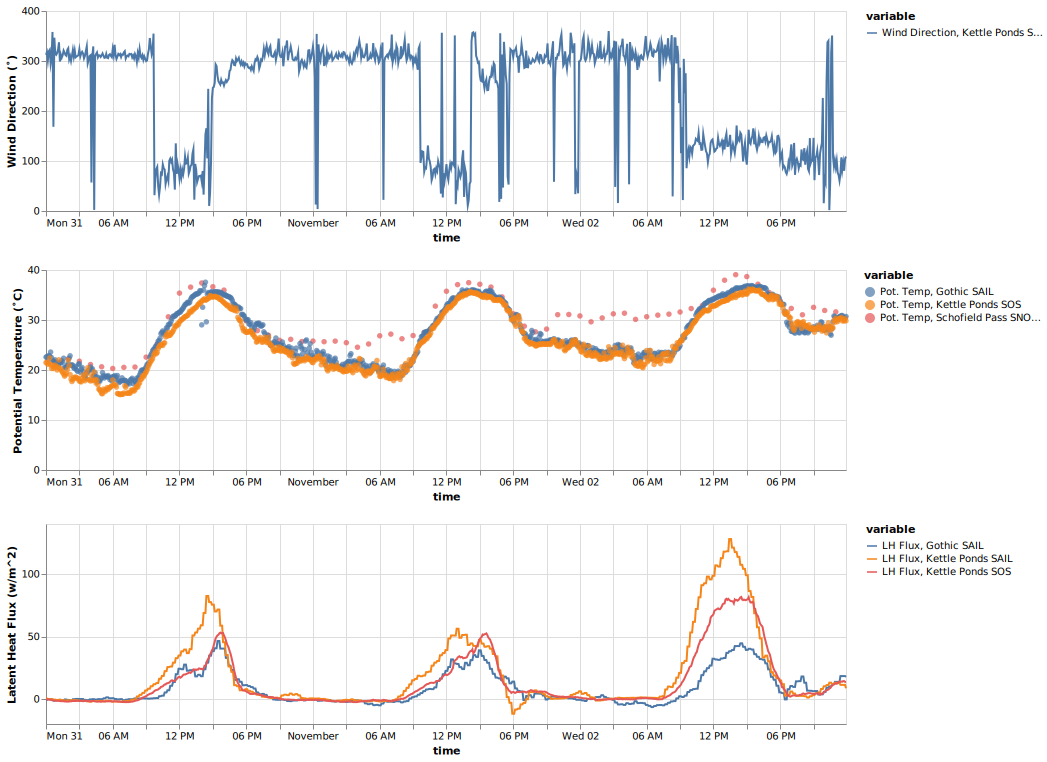

In [ ]:
alt.VConcatChart(
    data = time_series_data_tidy,
    vconcat = [wind_dir_chart, potential_temp_chart, latent_heat_chart]
).resolve_scale(color='independent', x='shared').transform_filter(
    'date(datum.time) != 30'
).transform_filter(
    'date(datum.time) != 3'
)

## Potential temperature and wind profiles

In [ ]:
# sos_tidy_temps = sos_ds[[f for f in sos_ds.data_vars if f.startswith('T_') or f.startswith('Tpot_')]]
sos_tidy_temps_ds = sos_ds[[f for f in sos_ds.data_vars if f.startswith('T_') or f.startswith('Tpot_') or f.startswith('spd_', ) or f.startswith('w_h2o__') or f.startswith('u_h2o__') or f.startswith('v_h2o__')]]

sos_tidy_temps_ds = sos_tidy_temps_ds.sel(time=slice(
    datetime.datetime.strptime(datelist[0], DATE_FORMAT_STR),
    datetime.datetime.strptime(datelist[-1], DATE_FORMAT_STR)
))

sos_tidy_temps = sos_tidy_temps_ds.resample(time='360Min').mean().to_dataframe().reset_index()
sos_tidy_temps_1_hr = sos_tidy_temps_ds.resample(time='60Min').mean().to_dataframe().reset_index()

sos_tidy_temps = sos_tidy_temps.melt(id_vars='time')
sos_tidy_temps['height'] = sos_tidy_temps['variable'].apply(sosutils.height_from_variable_name)
sos_tidy_temps['tower'] = sos_tidy_temps['variable'].apply(sosutils.tower_from_variable_name)
sos_tidy_temps['measurement'] = sos_tidy_temps['variable'].apply(sosutils.measurement_from_variable_name)

sos_tidy_temps_1_hr = sos_tidy_temps_1_hr.melt(id_vars='time')
sos_tidy_temps_1_hr['height'] = sos_tidy_temps_1_hr['variable'].apply(sosutils.height_from_variable_name)
sos_tidy_temps_1_hr['tower'] = sos_tidy_temps_1_hr['variable'].apply(sosutils.tower_from_variable_name)
sos_tidy_temps_1_hr['measurement'] = sos_tidy_temps_1_hr['variable'].apply(sosutils.measurement_from_variable_name)


In [ ]:
sos_tidy_temps_1_hr.time.min(), sos_tidy_temps_1_hr.time.max()

(Timestamp('2022-10-31 00:00:00'), Timestamp('2022-11-02 23:00:00'))

WARN facet encoding should be discrete (ordinal / nominal / binned).


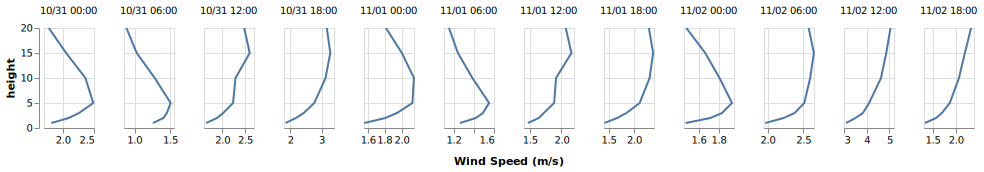

In [ ]:
alt.Chart(sos_tidy_temps).transform_filter(
    alt.datum.measurement == 'wind speed'
).mark_line().encode(
    alt.X('value:Q', sort='-y', title=None),
    alt.Y('height:Q'),
    alt.Facet('time:T', header=alt.Header(format="%m/%d %H:00", formatType='time'), title='Wind Speed (m/s)')
).properties(
    width=50, 
    height=100
).resolve_scale(
    x='independent'
).configure_header(
    titleOrient='bottom'
)

WARN facet encoding should be discrete (ordinal / nominal / binned).


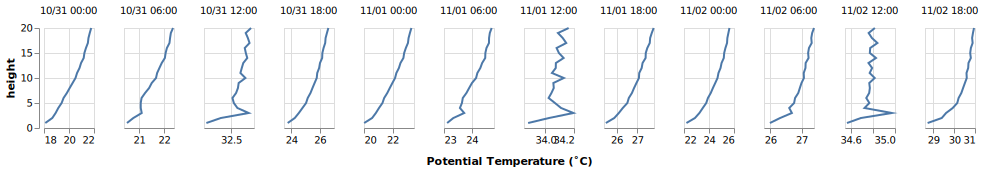

In [ ]:
alt.Chart(sos_tidy_temps).transform_filter(
    alt.datum.measurement == 'potential temperature'
).mark_line().encode(
    alt.X('value:Q', sort='-y', title=None),
    alt.Y('height:Q'),
    alt.Facet('time:T', header=alt.Header(format="%m/%d %H:00", formatType='time'), title='Potential Temperature (˚C)')
).properties(
    width=50, 
    height=100
).resolve_scale(
    x='independent'
).configure_header(
    titleOrient='bottom'
)

In [ ]:
sos_tidy_temps.loc[sos_tidy_temps.measurement == 'u_h2o_', 'value'] = sos_tidy_temps.loc[sos_tidy_temps.measurement == 'u_h2o_']['value']*1000
sos_tidy_temps.loc[sos_tidy_temps.measurement == 'v_h2o_', 'value'] = sos_tidy_temps.loc[sos_tidy_temps.measurement == 'v_h2o_']['value']*1000
sos_tidy_temps.loc[sos_tidy_temps.measurement == 'w_h2o_', 'value'] = sos_tidy_temps.loc[sos_tidy_temps.measurement == 'w_h2o_']['value']*1000



WARN facet encoding should be discrete (ordinal / nominal / binned).


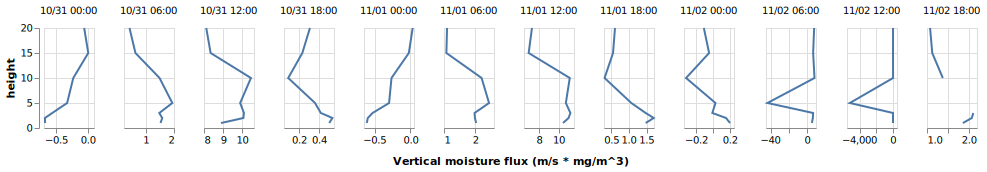

In [ ]:
alt.Chart(sos_tidy_temps).transform_filter(
    alt.datum.measurement == 'w_h2o_'
).mark_line().encode(
    alt.X('value:Q', sort='-y', title=None),
    alt.Y('height:Q'),
    alt.Facet('time:T', header=alt.Header(format="%m/%d %H:00", formatType='time'), title='Vertical moisture flux (m/s * mg/m^3)')
).properties(
    width=50, 
    height=100
).resolve_scale(
    x='independent'
).configure_header(
    titleOrient='bottom'
)

## Detailed hourly wind profiles for one day

In [ ]:
sos_tidy_temps_1_hr['day_hour'] = sos_tidy_temps_1_hr['time'].dt.strftime('%D %H')
sos_tidy_temps_1_hr['date'] = sos_tidy_temps_1_hr['time'].dt.date
sos_tidy_temps_1_hr['day'] = sos_tidy_temps_1_hr['time'].dt.day
sos_tidy_temps_1_hr['hour'] = sos_tidy_temps_1_hr['time'].dt.hour
sos_tidy_temps_1_hr['minute'] = sos_tidy_temps_1_hr['time'].dt.minute
sos_tidy_temps_1_hr['hour_group'] = pd.cut(
    sos_tidy_temps_1_hr['hour'],
    [-1, 7, 15, 24],
    labels=['0-7', '8-15', '16-24']
)

In [ ]:
sos_tidy_temps_1_hr.time.min(), sos_tidy_temps_1_hr.time.max()

(Timestamp('2022-10-31 00:00:00'), Timestamp('2022-11-02 23:00:00'))

In [ ]:
sos_tidy_temps_1_hr

,time,variable,value,height,tower,measurement,day_hour,date,day,hour,minute,hour_group
0,2022-10-31 00:00:00,spd_1m_c,1.987552,1,c,wind speed,10/31/22 00,2022-10-31,31,0,0,0-7
1,2022-10-31 01:00:00,spd_1m_c,1.679970,1,c,wind speed,10/31/22 01,2022-10-31,31,1,0,0-7
2,2022-10-31 02:00:00,spd_1m_c,1.762965,1,c,wind speed,10/31/22 02,2022-10-31,31,2,0,0-7
3,2022-10-31 03:00:00,spd_1m_c,1.727595,1,c,wind speed,10/31/22 03,2022-10-31,31,3,0,0-7
4,2022-10-31 04:00:00,spd_1m_c,1.734690,1,c,wind speed,10/31/22 04,2022-10-31,31,4,0,0-7
...,...,...,...,...,...,...,...,...,...,...,...,...
4891,2022-11-02 19:00:00,Tpot_20m_c,31.200796,20,c,potential temperature,11/02/22 19,2022-11-02,2,19,0,16-24
4892,2022-11-02 20:00:00,Tpot_20m_c,30.418793,20,c,potential temperature,11/02/22 20,2022-11-02,2,20,0,16-24
4893,2022-11-02 21:00:00,Tpot_20m_c,29.849089,20,c,potential temperature,11/02/22 21,2022-11-02,2,21,0,16-24
4894,2022-11-02 22:00:00,Tpot_20m_c,30.046362,20,c,potential temperature,11/02/22 22,2022-11-02,2,22,0,16-24


WARN column encoding should be discrete (ordinal / nominal / binned).


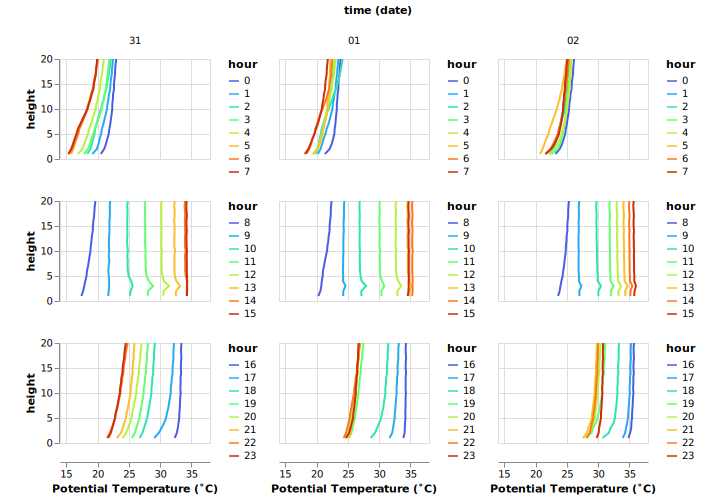

In [ ]:
alt.Chart(sos_tidy_temps_1_hr).transform_filter(
    alt.datum.measurement == 'potential temperature'
).mark_line().encode(
    alt.X('value:Q', sort='-y', title='Potential Temperature (˚C)'),
    alt.Y('height:Q'),
    alt.Color("hour:O", scale=alt.Scale(scheme='turbo')),
    # alt.Facet("hour_group:O", sort=['0-6', '6-12', '12-18', '18-24'], columns=2)
).properties(width=150, height=100).facet(
    row=alt.Row('hour_group:O', sort=['0-7', '8-15', '16-24'], title=None, header=alt.Header(labelExpr="''")),
    column=alt.Column('date(time):T', sort=[31,1,2])
).resolve_scale(
    color='independent', 
    # x='independent'
)

WARN column encoding should be discrete (ordinal / nominal / binned).


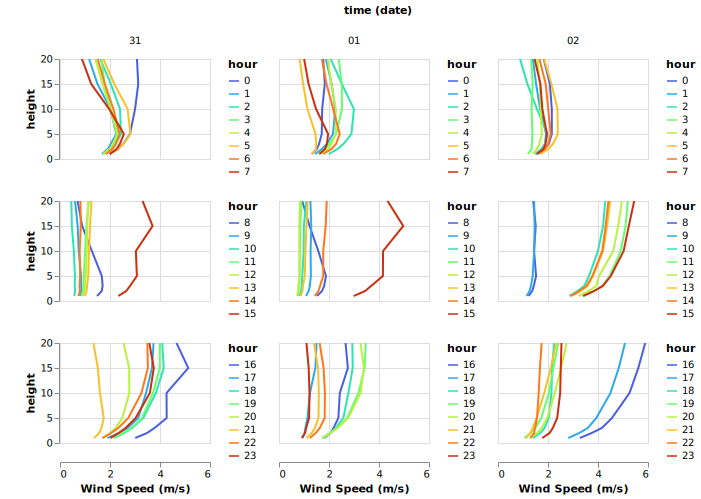

In [ ]:
alt.Chart(sos_tidy_temps_1_hr).transform_filter(
    alt.datum.measurement == 'wind speed'
).mark_line().encode(
    alt.X('value:Q', sort='-y', title='Wind Speed (m/s)'),
    alt.Y('height:Q'),
    alt.Color("hour:O", scale=alt.Scale(scheme='turbo')),
    # alt.Facet("hour_group:O", sort=['0-6', '6-12', '12-18', '18-24'], columns=2)
).properties(width=150, height=100).facet(
    row=alt.Row('hour_group:O', sort=['0-7', '8-15', '16-24'], title=None, header=alt.Header(labelExpr="''")),
    column=alt.Column('date(time):T', sort=[31,1,2])
).resolve_scale(
    color='independent', 
    # x='independent'
)

# Rotate coordinate system for limited time period

In [ ]:
tidy_df = sosutils.get_tidy_dataset(sos_ds, VARIABLE_NAMES)

# NIGHTIME DOWNVALLEY WIND
# tidy_df = tidy_df[
#     (tidy_df.time > datetime.datetime(2022, 12, 18, 0)) &
#     (tidy_df.time < datetime.datetime(2022, 12, 18, 2))
# ]

# DAYTIME UPVALLEY WIND
tidy_df = tidy_df[
    (tidy_df.time > datetime.datetime(2022, 12, 18, 13)) &
    (tidy_df.time < datetime.datetime(2022, 12, 18, 15))
]

In [ ]:
tidy_streamwise_df = sosutils.streamwise_coordinates_single_rotation_tidy_df(tidy_df)

### Look at changes to vector variables

In [ ]:

alt.Chart(
    pd.concat([
        tidy_df.assign(coordinates='Sonic'),
        tidy_streamwise_df.assign(coordinates='Streamwise')
    ])
).transform_filter(
    alt.FieldOneOfPredicate('height', [1,2,3,5,10,15,20]) # limite to measurements at sonic heights
).transform_filter(
    alt.FieldOneOfPredicate('measurement', [
        'u','v','u_w_','v_w_','u_tc_','v_tc_','u_h2o_','v_h2o_',
    ]) # limit to measurements at sonic heights
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('coordinates:N')
).properties(
    width=150,
    height=50
).facet(
    column = 'height:O',
    row = 'measurement'
).resolve_scale(y='independent')

# Calculate nondimensional numbers

## **Obhukov Length**

$$ L = \frac{
  u_*^3 \overline{\theta_v}
}{
  k g \overline{w'\theta'_v}
}
$$

$u_*$ = local scale/shear velocity

$\overline{\theta_v} $ = virtual potential temperature (mean over reynolds-averaging period)

$ \overline{w'\theta'_v} $ = vertical turbulent flux of sensible heat (in terms of virtual potential temperature, mean over reynolds-averaging period)

$k$ = von kármán constant

$$ u_* = \sqrt{\frac{\overline{u'w'}}{\rho}} $$


$\overline{u'w'}$ = vertical turbulent flux of momentum (mean over reynolds-averaging period)

$\rho$ = air density

To calculate the shear velocity we need to rotate the coordinate system to point upstream.

In [ ]:
import metpy.constants
import metpy.calc
from metpy.units import units
import pint

In [ ]:
TOWER = 'c'
HEIGHT = 3

PRESSURE_TOWER = 'c'
PRESSURE_HEIGHT = 10

# Note that I need to use xarray datasets here for metpy/pint units and metpy functions work 
tidy_streamwise_indexed_df = tidy_streamwise_df.set_index(['time', 'tower', 'height', 'measurement',])

# We have pressure and temperature
pressure = xr.DataArray(tidy_streamwise_indexed_df.loc[:, PRESSURE_TOWER, PRESSURE_HEIGHT, 'pressure']['value']) * units.millibar
temperature = xr.DataArray(tidy_streamwise_indexed_df.loc[:, TOWER, HEIGHT, 'temperature']['value']) * units.celsius

# We need mixing ratio to calculate air density, which we can calculate with P, T, and Relative Humidity
#   see: http://www.atmo.arizona.edu/students/courselinks/fall12/atmo336/lectures/sec1/humidity.html
# Note: we need to convert RH to a fraction as it comes in percent units (ie .7 is 70.)
mixing_ratio = xr.DataArray(tidy_streamwise_indexed_df.loc[:, TOWER, HEIGHT, 'RH']['value']/100) * metpy.calc.saturation_mixing_ratio(
    pressure,
    temperature
)
air_density = metpy.calc.density(pressure, temperature, mixing_ratio)

# Now calculate shear velocity
vertical_turb_momentum_flux = xr.DataArray(tidy_streamwise_indexed_df.loc[:, TOWER, HEIGHT, 'u_w_']['value']) * units('m/s') * units('m/s')
shear_velocity = ((vertical_turb_momentum_flux)**2)**(1/4)

virtual_temperature = xr.DataArray(tidy_streamwise_indexed_df.loc[:, TOWER, HEIGHT, 'virtual temperature']['value']) * units.celsius
vertical_velocity_virtual_temperature_covariance = xr.DataArray(tidy_streamwise_indexed_df.loc[:, TOWER, HEIGHT, 'w_tc_']['value']) * units('m/s') * units.celsius

virtual_potential_temperature = metpy.calc.potential_temperature(
    pressure,
    virtual_temperature
)

vertical_velocity_virtual_potential_temperature_covariance = metpy.calc.potential_temperature(
    pressure,
    vertical_velocity_virtual_temperature_covariance / units('m/s')
) * units('m/s')

k = 0.4
g = metpy.constants.earth_gravity

$ L = \frac{
  u_*^3 \overline{\theta_v}
}{
  k g \overline{w'\theta'_v}
}
$

$ u_* = ((\overline{u'w'})^2)^{1/4}$


In [ ]:
obukhov_length = - (shear_velocity**3)*virtual_potential_temperature/(k*g*vertical_velocity_virtual_potential_temperature_covariance)

In [ ]:
print("Obukhov length, mean of the time series of calculated lengths")
print(obukhov_length.mean())

In [ ]:
virtual_potential_temperature

In [ ]:
print("Obukhov length, calculated from mean inputs")
print(
    - (shear_velocity.mean()**3)*virtual_potential_temperature.mean()/ \
        (k*g*vertical_velocity_virtual_potential_temperature_covariance.mean())
)

In [ ]:

fig, axes = plt.subplots(7,1, figsize=(10,7), sharex=True)

pressure.name = 'Pressure'
pressure.plot.scatter(ax=axes[0])
axes[0].set_ylabel("Pressure\n(millibars)")

mixing_ratio.name = 'Mixing ratio'
mixing_ratio.plot.scatter(ax=axes[1])
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set_ylabel("Mixing ratio")

vertical_turb_momentum_flux.name = "u'w'"
vertical_turb_momentum_flux.plot.scatter(ax=axes[2])
axes[2].set_ylabel("u'w' (m^2/s^2)")

shear_velocity.name = 'Shear velocity'
shear_velocity.plot.scatter(ax=axes[3])
axes[3].yaxis.set_label_position("right")
axes[3].yaxis.tick_right()
axes[3].set_ylabel("Shear\n velocity (m/s)")


virtual_potential_temperature.name = 'Virtual Pot. Temp'
virtual_potential_temperature.plot.scatter(ax=axes[4])
axes[4].set_ylabel("Virtual Pot.\nTemperature (K)")

vertical_velocity_virtual_potential_temperature_covariance.name = r"w'θv'"
vertical_velocity_virtual_potential_temperature_covariance.plot.scatter(ax=axes[5])
axes[5].yaxis.set_label_position("right")
axes[5].yaxis.tick_right()
axes[5].set_label("w'θv'\n(K m/s)")


obukhov_length.name = 'L'
obukhov_length.plot.scatter(ax=axes[6])
# axes[6].set_ylim(-.2,.2)
axes[6].set_label("L (m)")

# for ax in axes:
#     ax.yaxis.label.set_fontsize(8)

# Apply M.O.S.T. Models

Holtslag and de Bruin (1988) 

$$ \Phi_m (z/L) = 1 + 0.7(z/L) + 0.75(z/L)(6 - 0.35(z/L))exp(-0.35(z/L))$$

$$ \frac{d\overline{u}}{dz} = \frac{u_*}{k z} \Phi_m(z/L) $$

$$ \overline{u} = \int \frac{u_*}{k z} \Phi (z/L) dz $$

Using wolfram to integrate the above (treating $u_*$ and  $k$ as constants),

$$ \overline{u} = (u_*/k)(1/L)(e^{-0.35 z/L}(0.75 z - 10.7143L)) + (1/L)0.7z + log(z)$$ 

In [ ]:
def profile_function(z, L, shear_velocity):
    k = 0.4
    return (shear_velocity/k)*(1/L)*(np.exp(-0.35*z/L)*(0.75*z - 10.7143*L)) + (1/L)*0.7*z + np.log(z)

In [ ]:
mean_obukhov_length = obukhov_length.mean().values.item()
mean_shear_velocity = shear_velocity.mean().values.item()

mean_obukhov_length, mean_shear_velocity

In [ ]:
profile_comparison_df = tidy_streamwise_indexed_df.groupby(['tower', 'height', 'measurement']).mean().loc['c', :, 'u'].reset_index()

In [ ]:
profile_comparison_df['value_model'] = profile_comparison_df['height'].apply(lambda height: profile_function(height, mean_obukhov_length, mean_shear_velocity))

In [ ]:
profile_comparison_df

In [ ]:
profile_comparison_df.plot('value', 'height')
profile_comparison_df.plot('value_model', 'height')